# Project 3: Kaggle Competition - Semantic Segmentation


#### <font style="color:green">Maximum Points: 100</font>

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3><center>Sections</center></h3></td> <td><h3><center>Points</center></h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Custom Dataset Class</h3></td> <td><h3><center>7</center></h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Visualize Dataset</h3></td> <td><h3><center>3</center></h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Loss Function</h3></td> <td><h3><center>5</center></h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Evaluation Metrics</h3></td> <td><h3><center>5</center></h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3><center>10</center></h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Train and Plot Results</h3></td> <td><h3><center>7</center></h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Inference</h3></td> <td><h3><center>3</center></h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>Prepare Submission CSV</h3></td><td><h3><center>10</center></h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Submission Score</h3></td> <td><h3><center>50</center></h3></td> </tr>
    </table>
</div>

**Kaggle Submission Score Points Distribution on Public Test Set**


<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Public Test Set Dice Score</h3></td> <td><h3><center>Points</center></h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3> <center>&le; 79%</center></h3></td><td><h3><center>0</center></h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3><center>80%</center></h3></td><td><h3><center>10</center></h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3><center>81%</center></h3></td><td><h3><center>20</center></h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3> <center>82%</center></h3></td><td><h3><center>30</center></h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3> <center>83%</center></h3></td><td><h3><center>40</center></h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3><center> &ge; 84%</center></h3></td><td><h3><center>50</center></h3></td> </tr>
    </table>
</div>

**Note: Percentages will be rounded off to the nearest integer.**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other. You are free to take references from any online resource.</font>**

----------

In [1]:
# Colab-gdrive import
from google.colab import drive; drive.mount("/remote/")

# Built-in imports
import os
import platform
import glob as glob
import csv
import json

# Third-party imports
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras as tfk
import albumentations as alb

from dataclasses import dataclass
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)


# Custom imports

Mounted at /remote/


In [2]:
# System Configuration
block_plot = False
plt.rcParams['image.cmap'] = 'gray'

DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

def system_config(SEED_VALUE):
  np.random.seed(SEED_VALUE)
  tf.random.set_seed(SEED_VALUE)

  # Get list of GPUs.
  gpu_devices = tf.config.list_physical_devices('GPU')
  print(gpu_devices)

  if gpu_devices.__len__() > 0:
    print('Using GPU')
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    # If there are any gpu devices, use first gpu.
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    # Grow the memory usage as it is needed by the process.
    # tf.config.experimental.set_memory_growth(gpu_devices[0], True)  ## Throws errrors on colab
    # Enable using cudNN.
    os.environ['TF_USE_CUDNN'] = "true"
  else:
    print('Using CPU')

system_config(7)

[]
Using CPU


In [17]:
@dataclass(frozen=True)
class DatasetConfig:
  """Dataset configuration class.

  Reference:
    https://ieeexplore.ieee.org/document/9460988
    https://github.com/BinaLab/FloodNet-Supervised_v1.0

  """
  NUM_CLASSES: int = 10
  IMG_WIDTH:   int = 256
  IMG_HEIGHT:  int = 256
  SHAPE:     tuple = (256, 256, 3)
  SIZE:      tuple = (512, 384)

  DATASET_DIR: str = "/remote/MyDrive/shared/dataset/FloodNet-Supervised-Tiny_v1.0"
  DATA_TRAIN_IMAGES: str = f"{DATASET_DIR}/train/images/*.jpg"
  DATA_TRAIN_LABELS: str = f"{DATASET_DIR}/train/masks/*.png"
  # DATA_VALID_IMAGES: str = f"{DATASET_DIR}/valid/images/*.jpg"
  # DATA_VALID_LABELS: str = f"{DATASET_DIR}/valid/masks/*.png"
  DATA_TEST_IMAGES:  str = f"{DATASET_DIR}/test/images/*.jpg"
  # DATA_TEST_LABELS:  str = f"{DATASET_DIR}/test/masks/*.png"

  ID2COLOR = {
    0: (0, 0, 0),       # Background
    1: (255, 0, 0),     # Building Flooded
    2: (200, 90, 90),   # Non-Flooded Building
    3: (128, 128, 0),   # Road Flooded
    4: (155, 155, 155), # Non-Flooded Road
    5: (0, 255, 255),   # Water
    6: (55, 0, 255),    # Tree
    7: (255, 0, 255),   # Vehicle
    8: (245, 245, 0),   # Pool
    9: (0, 255, 0),     # Grass
  }


@dataclass
class OptimizerConfig:
  INIT_LEARING_RATE = 1e-4
  # Amount of additional regularization on the values of the weights
  WEIGHT_DECAY = 1e-5
  # At which epochs should we make a "step" in the learning rate (i.e. decrease it in some manner)
  # STEP_MILESTONE = (32,) # Assuming we are  training for 64 epochs
  STEP_MILESTONE = (25,) # Assuming we are  training for 50 epochs
  # Multiplier applied to current learning rate at each of STEP_MILESTONE
  GAMMA: float = 0.1


@dataclass(frozen=True)
class TrainingConfig:
  BATCH_SIZE:      int = 8
  EPOCHS:          int = 50
  LEARNING_RATE: float = 1e-4  # short for: float = 0.0001

  MULTIPROCESSING: bool = True if platform.system()=="Linux" else False

  CHECKPOINT_DIR: str = "/remote/MyDrive/code/darkest/resources/models/deeplabv3.h5"


@dataclass(frozen=True)
class InferenceConfig:
  NUM_BATCHES:     int = 3

## 1. Custom Dataset Class [7 Points]

<font style="color:red">In this section you have to implement your own dataset generator.</font>

You can either the `Sequence` class or `tf.data` API or any other method to create training and validation data generators.

**Note:** There is no separate validation data, so you will have to create your own validation set by dividing training set into train and validation sets.


For example:

```python

class CustomSegmentationDataset(Sequence):
    
    def __init__(self, *, batch_size, image_size, image_paths, mask_paths, num_classes, apply_aug):
        '''
        Generic Dataset class for semantic segmentation datasets
        
        Arguments:
            batch_size:  Number of samples to be included in each batch of data.
            image_size:  Image and mask size to be used for training.
            image_paths: Path to image directory.
            mask_paths:  Path to masks directory.
            num_classes: Total number of classes present in dataset.
            apply_aug:   Should augmentations be applied.
        '''

```

In [47]:
class SegmentationDataset(tfk.utils.Sequence):
  """Segmentation dataset class.
  """

  def __init__(self, *, batch_size, image_size, image_paths, mask_paths, num_classes, color_map, apply_aug):
    """Generic Dataset class for semantic segmentation datasets.

    Arguments:
      batch_size:  Number of samples to be included in each batch of data.
      image_size:  Image and mask size to be used for training.
      image_paths: Path to image directory.
      mask_paths:  Path to masks directory.
      num_classes: Total number of classes present in dataset.
      apply_aug:   Should augmentations be applied.

    """
    self.batch_size  = batch_size
    self.image_size  = image_size
    self.image_paths = image_paths
    self.mask_paths  = mask_paths
    self.num_classes = num_classes
    self.color_map = color_map
    self.aug = apply_aug

    self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
    self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

    if self.aug:
      self.train_transforms = self.transforms()

    self.resize_transforms = self.resize()


  def __len__(self):
    return self.mask_paths.__len__() // self.batch_size


  def transforms(self):
    train_transforms = alb.Compose([
      alb.HorizontalFlip(p=0.5),
      alb.VerticalFlip(p=0.5),
      alb.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0.2, shift_limit=0.2, p=0.5, border_mode=0)
      # alb.RandomResizedCrop(height=self.image_size[0], width=self.image_size[1], scale=(0.8, 1.0), p=0.5),
    ])
    return train_transforms


  def resize(self):
    resize_transforms = alb.Resize(
      height=self.image_size[0], width=self.image_size[1],
      interpolation=cv.INTER_NEAREST,
      always_apply=True, p=1
    )
    return resize_transforms


  def reset_array(self):
    self.x.fill(0.)
    self.y.fill(0.)


  def __getitem__(self, idx):
    self.reset_array()
    i = idx * self.batch_size
    batch_image_paths = self.image_paths[i : i + self.batch_size]
    batch_mask_paths = self.mask_paths[i : i + self.batch_size]

    for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):
      # Read the image and convert to RGB.
      img = cv.imread(input_image)
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

      # Read the mask and convert to RGB.
      msk = cv.imread(input_mask)
      msk = cv.cvtColor(msk, cv.COLOR_BGR2RGB)

      # Resize the image and mask.
      resized  = self.resize_transforms(image=img, mask=msk)
      img, msk = resized['image'], resized['mask']

      if self.aug:
        # Apply augmentations.
        train_augment = self.train_transforms(image=img, mask=msk)
        img, msk = train_augment['image'], train_augment['mask']

      # Store image in x.
      # self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]
      self.x[j] = img

      msk = self.rgb_to_onehot(msk, self.color_map, self.num_classes)

      self.y[j] = msk.argmax(-1)

    return self.x, self.y


  @classmethod
  def rgb_to_onehot(cls, rgb_arr, color_map, num_classes):
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
      arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr




def create_datasets(aug=False, split_ratio:float=0.8, batch_size:int=8):
  """Creates the train and validation datasets from given images - stripped kaggle ds.
  """
  train_images = sorted(glob.glob(DatasetConfig.DATA_TRAIN_IMAGES))
  train_masks  = sorted(glob.glob(DatasetConfig.DATA_TRAIN_LABELS))
  split_index = int(train_images.__len__() * split_ratio)
  # print(split_index)  # 1474
  return (
    SegmentationDataset(  # Train data loader.
      batch_size=batch_size,
      image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
      image_paths=train_images[:split_index],
      mask_paths=train_masks[:split_index],
      num_classes=DatasetConfig.NUM_CLASSES,
      color_map=DatasetConfig.ID2COLOR,
      apply_aug=aug,
    ),
    SegmentationDataset(  # Validation data loader.
      batch_size=batch_size,
      image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
      image_paths=train_images[split_index:],
      mask_paths=train_masks[split_index:],
      num_classes=DatasetConfig.NUM_CLASSES,
      color_map=DatasetConfig.ID2COLOR,
      apply_aug=False,
    )
  )


train_ds, valid_ds = create_datasets(aug=True)

## 2. Visualize Dataset [3 Points]


<font style="color:red">In this section, you have to plot any 3 images from the training set with their corresponding masks and an overlayed image.</font>


For example:

---
---

<img src="https://learnopencv.com/wp-content/uploads/2022/06/c4-project3-GT.png">

---

In [48]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=DatasetConfig.ID2COLOR):
  single_layer = np.squeeze(num_arr)
  output = np.zeros(num_arr.shape[:2]+(3,))
  for k in color_map.keys():
    output[single_layer==k] = color_map[k]
  return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]


# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):
  alpha = 1.0 # Transparency for the original image.
  beta  = 0.7 # Transparency for the segmentation map.
  gamma = 0.0 # Scalar added to each sum.
  segmented_image = cv.cvtColor(segmented_image, cv.COLOR_RGB2BGR)
  image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
  image = cv.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  # return np.clip(image, 0.0, 1.0)  # should be handeled in a different way, np.clip clips the information in the image
  return image


def display_image_and_mask(data_list, color_mask=True, size=DatasetConfig.SIZE, color_map=DatasetConfig.ID2COLOR):
  plt.figure(figsize=(16, 6))
  title = ['Ground Truth Image', 'Ground Truth Mask', 'Overlayed Mask']

  grayscale_gt_mask = cv.resize(data_list[1], size, interpolation=cv.INTER_NEAREST)
  rgb_gt_mask = num_to_rgb(grayscale_gt_mask, color_map=color_map)
  overlayed_image = image_overlay(cv.resize(data_list[0], size, interpolation=cv.INTER_NEAREST), rgb_gt_mask)

  data_list.append(np.clip(overlayed_image, 0.0, 1.0))

  for i in range(data_list.__len__()):
    plt.subplot(1, data_list.__len__(), i+1)
    plt.title(title[i])
    if title[i] == 'Ground Truth Mask':
      if color_mask:
        plt.imshow(np.array(rgb_gt_mask))
      else:
        plt.imshow(np.array(grayscale_gt_mask))
    else:
      plt.imshow(np.array(cv.resize(data_list[i], size, interpolation=cv.INTER_NEAREST)))
    plt.axis('off')

  plt.show()

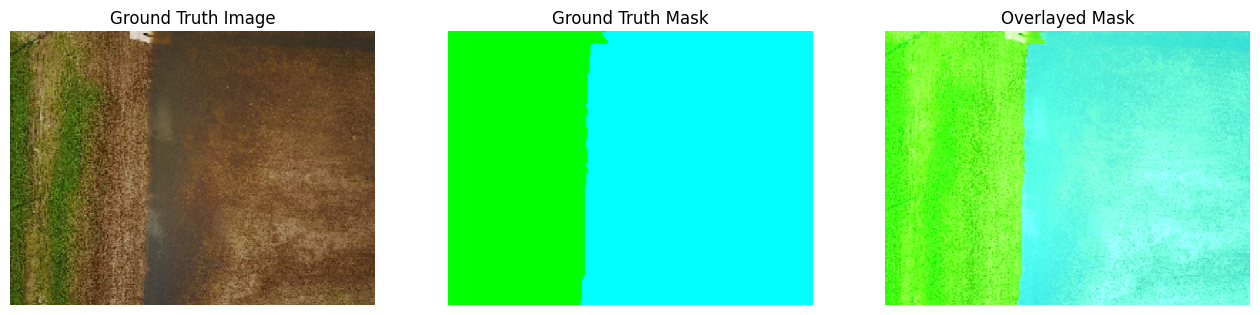

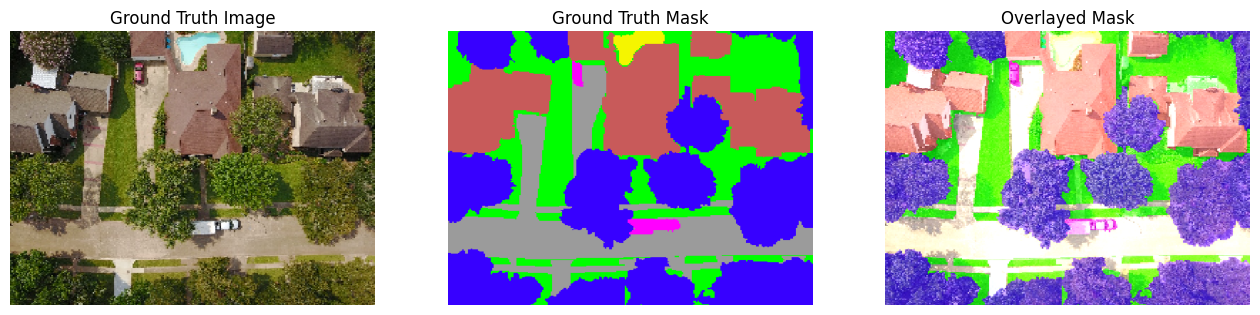

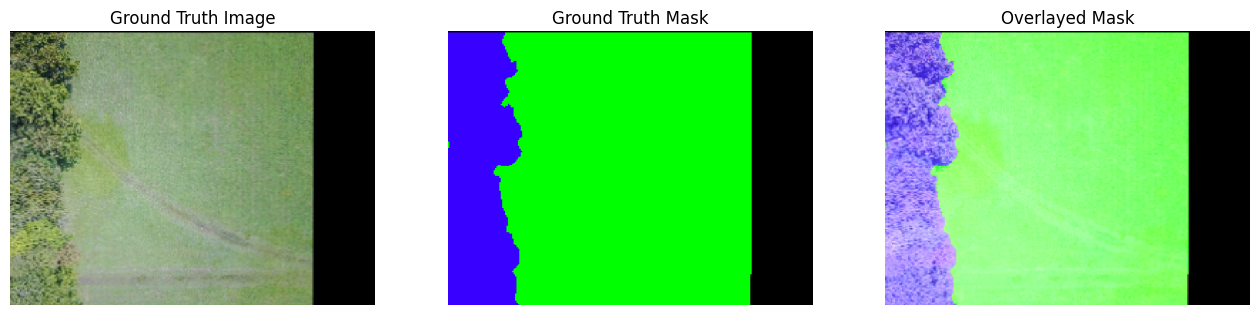

In [49]:
for i, (images, masks) in enumerate(train_ds):
  if i == 3: break
  display_image_and_mask(
    [images[0]/255, masks[0]],   # because reasons 1
    color_map=DatasetConfig.ID2COLOR
  )

## 3. Loss Function  [5 Points]

<font style="color:red">In this section, you have to implement the loss function you will be using for this dataset.</font>

1. The loss function can be `Cross-entropy`, `focal loss`, `IoU` or `Dice`.
2. You can also use a combination of the above mentioned functions.
3. You can also free to implement and use loss functions not taught in this course.

In [6]:
def dice_coef_loss(y_true, y_pred):
    """
    Arguments:
    y_true (ndarray or tensor): Ground truth mask (G). Shape: (batch_size, height, width)
                                Sparse representation of segmentation mask.

    y_pred (ndarray or tensor): Softmax prediction (P) from the model.
                                Shape: (batch_size, height, width, num_classes).

    return (scalar): Loss
    """
    num_classes = y_pred.shape[-1]

    # Convert single channel ground truth labels to one-hot encoding for metric computation.
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)

    # Axes corresponding to image width and height: [B, H, W, C].
    axes = (1, 2)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Dice coefficient. Shape: (batch_size, num_classes)
    eps = 1e-3
    dc = (2. *  intersection + eps) / (total + eps)

    # Compute the mean over the remaining axes (batch and classes).
    dc_mean = tf.math.reduce_mean(dc)

    # Compute cross-entropy loss.
    CCE =  tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    return 1.0 - dc_mean + CCE

## 4. Evaluation Metrics [5 Points]

<font style="color:red">In this section, you have to implement the Dice coefficient evaluation metric.</font>

This competition is evaluated on the mean <a href="https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient" target="_blank">Dice coefficient</a>,  which helps compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:


<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be $1$ when both $X$ and $Y$ are empty.</p>



In [7]:
def mean_dice_naive(y_true, y_pred, axes=(1, 2), smooth=1e-6):
    num_classes = y_pred.shape[-1]

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: A == B --> TP
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=axes)

    # A + B --> 2TP + FP + FN
    total = tf.math.reduce_sum(y_true, axis=axes) + tf.math.reduce_sum(y_pred, axis=axes)

    # Dice: 2TP / (2TP + FP+ FN)
    dice = (2 * intersection + smooth) / (total + smooth)

    mean_dice = tf.math.reduce_mean(dice)
    return mean_dice

## 5. Model [10 Points]

<font style="color:red">In this section you have to define your segmentation model.</font>

In [8]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
  x = tfk.layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", use_bias=use_bias)(block_input)
  x = tfk.layers.BatchNormalization()(x)
  return tfk.layers.Activation('relu')(x)


def dilate_spatial_pyramid_pooling(dspp_input):
  dims = dspp_input.shape
  # Create a 1x1 feature map using AveragePooling2D.
  x = tfk.layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
  x = convolution_block(x, kernel_size=1, use_bias=True)

  # Upsample the feature map to the original size.
  out_pool = tfk.layers.UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(x)

  # Create feature maps of the same shape with different dilation rates.
  out_1  = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
  out_6  = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
  out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
  out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

  # Combine all the feature maps and process them through a 1x1 convolutional block.
  x = tfk.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
  output = convolution_block(x, kernel_size=1)

  return output


def deeplabv3plus(num_classes, shape):
  model_input = tfk.layers.Input(shape=shape)
  preprocessing = tfk.applications.resnet50.preprocess_input(model_input)
  backbone = tfk.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessing)

  # Set all layers in the backbone as trainable.
  for layer in backbone.layers:
    layer.trainable = True

  # Obtain a (lower resolution) feature map from the backbone.
  # Shape: (14, 14, 256)
  input_a = backbone.get_layer("conv4_block6_2_relu").output

  # Pass through Atrous Spatial Pyramid Pooling to obtain features at various scales.
  input_a = dilate_spatial_pyramid_pooling(input_a)

  # Upsample the concatenated features.
  input_a = tfk.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(input_a)

  # Obtain a second (higher resolution) feature map from the backbone and apply convolution.
  # Shape: (56, 56, 64)
  input_b = backbone.get_layer("conv2_block3_2_relu").output
  input_b = convolution_block(input_b, num_filters=256, kernel_size=1)

  # Concatenate both sets of feature maps and perform final decoder processing.
  x = tfk.layers.Concatenate(axis=-1)([input_a, input_b])
  x = convolution_block(x)
  x = convolution_block(x)
  x = tfk.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

  # Apply 1x1 convolution to limit the depth of the feature maps to the number of classes.
  outputs = tfk.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

  model_output = tfk.layers.Activation('softmax')(outputs)
  model = tfk.Model(inputs=model_input, outputs=model_output)

  return model

## 6. Train and Plot Results [7 Points]

<font style="color:red">In this section you have to:</font>
    
1. Implement the training pipeline.

2. Train the model.

3. Plot loss and metrics for training and validation set.


In [10]:
def get_optimizer(steps_per_epoch=10, opt_config=OptimizerConfig):
  # If STEP_MILESTONE is not an empty array.
  if opt_config.STEP_MILESTONE.__len__():
    print("Using learning rate scheduler.")
    boundaries = []
    lr_values = []
    # Convert milestones in epoch to steps to get boundaries
    for epoch_milestone in opt_config.STEP_MILESTONE:
      step_milestone = steps_per_epoch * epoch_milestone
      boundaries.append(step_milestone)
    # Find the learning rate values for each boundary
    lr = opt_config.INIT_LEARING_RATE
    lr_values.append(lr)
    for idx in range(opt_config.STEP_MILESTONE.__len__()):
      lr *= opt_config.GAMMA
      lr_values.append(lr)
    print(f"Optimizer --> boundaries: {boundaries}, lr_values: {lr_values}")
    learning_rate = tfk.optimizers.schedules.PiecewiseConstantDecay(boundaries, lr_values)
  else:
    print("No scheduling applied.")
    learning_rate = opt_config.INIT_LEARING_RATE

  optimizer = tfk.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=opt_config.WEIGHT_DECAY,
  )

  return optimizer

In [11]:
def cb_checkpoint(save_best_only:bool=True, save_weights_only:bool=False):
  """Call back for saving the best model during training.
  """
  # Create a new checkpoint directory every time. - yeah otherwise throws an error but i only want the best weights / model - save over
  # if not os.path.exists(TrainingConfig.CHECKPOINT_DIR):
  #   os.makedirs(TrainingConfig.CHECKPOINT_DIR)

  return tfk.callbacks.ModelCheckpoint(
    filepath=TrainingConfig.CHECKPOINT_DIR,
    monitor='val_accuracy',
    mode="max",
    save_best_only=save_best_only,
    save_weights_only=save_weights_only,
    verbose=1,
  )

In [12]:
model = deeplabv3plus(num_classes=DatasetConfig.NUM_CLASSES, shape=DatasetConfig.SHAPE)

model.compile(
  optimizer=get_optimizer(steps_per_epoch=train_ds.__len__()),
  # loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=False),
  loss=dice_coef_loss,
  metrics=['accuracy', mean_dice_naive],
)

94765736/94765736 [==============================] - 1s 0us/step
Using learning rate scheduler.
Optimizer --> boundaries: [4600], lr_values: [0.0001, 1e-05]


In [13]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=TrainingConfig.EPOCHS,
  use_multiprocessing=TrainingConfig.MULTIPROCESSING,
  callbacks=[
    cb_checkpoint(),
  ],
  workers=4,
  verbose=1,
)

Epoch 1/50
 17/184 [=>............................] - ETA: 1:01:42 - loss: 2.8777 - accuracy: 0.4112 - mean_dice_naive: 0.1640

Process Keras_worker_ForkPoolWorker-4:
Process Keras_worker_ForkPoolWorker-2:
Process Keras_worker_ForkPoolWorker-3:
Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", li

KeyboardInterrupt: ignored

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
  fig, ax = plt.subplots(figsize=(18, 5))

  if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
    metrics = [metrics,]
    metric_name = [metric_name,]

  for idx, metric in enumerate(metrics):
    ax.plot(metric, color=color[idx])

  plt.xlabel("Epoch")
  plt.ylabel(ylabel)
  plt.title(ylabel)
  plt.xlim([0, TrainingConfig.EPOCHS-1])
  plt.ylim(ylim)
  # Tailor x-axis tick marks
  ax.xaxis.set_major_locator(MultipleLocator(5))
  ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.xaxis.set_minor_locator(MultipleLocator(1))
  plt.grid(True)
  plt.legend(metric_name)
  plt.show(block=block_plot)
  plt.close()


# Pixel Accuracy.
train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

# Mean Dice Naive.
train_dice = history.history["mean_dice_naive"]
valid_dice = history.history["val_mean_dice_naive"]

# Loss
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]
max_loss = max(max(train_loss), max(valid_loss))

plot_results(
  [train_acc, valid_acc],
  ylabel="Pixel Accuracy",
  ylim = [0.5, 1.0],
  metric_name=["Training Accuracy", "Validation Accuracy"],
  color=["g", "b"]
)

plot_results(
  [train_dice, valid_dice],
  ylabel="Mean Dice Naive",
  ylim = [0.0, 1.0],
  metric_name=["Training Mean Dice Naive", "Validation Mean Dice Naive"],
  color=["g", "b"]
)

plot_results(
  [train_loss, valid_loss],
  ylabel="Cross Entropy Loss",
  ylim=[0.0, max_loss],
  metric_name=["Training Loss", "Validation Loss"],
  color=["g", "b"]
)

NameError: ignored

## 7. Inference [3 Points]


<font style="color:red">Plot inferences on 3 random images from your validation set.</font>

<font style="color:green">Note: Inference should be performed on the original image size and not on any resized image.</font>

**E.g., if the original image has (H, W) of (512, 384) and your model returns a final output (H', W') shape of (256, 256).
You need to resize your outputs to size (512, 384) before plotting.**


Example plots:

---
---

<img src='https://learnopencv.com/wp-content/uploads/2022/06/c4-project3-Preds.png'>


---


In [14]:
trained_model = tf.keras.models.load_model(
  TrainingConfig.CHECKPOINT_DIR,
  custom_objects={
      'mean_dice_naive':mean_dice_naive,
      'dice_coef_loss':dice_coef_loss,
  }
)

evaluate = trained_model.evaluate(valid_ds)
print(f"Model evaluation accuracy: {evaluate[1]*100:.2f} %")
print(f"Model evaluation mean dice naive: {evaluate[2]*100:.2f} %")

46/46 [==============================] - 301s 7s/step - loss: 0.7964 - accuracy: 0.8152 - mean_dice_naive: 0.7833
Model evaluation accuracy: 81.52 %
Model evaluation mean dice naive: 78.33 %


In [54]:
def dir_inference(image_dir, mask_dir, trained_model, img_idxs=[16, 99, 200], size=DatasetConfig.SIZE, split_ratio:float=0.8):

  all_images = sorted(glob.glob(f"{image_dir}"))
  all_masks  = sorted(glob.glob(f"{mask_dir}"))
  split_index = int(all_images.__len__() * split_ratio)
  # Cut the train set because reasons 3
  val_images = all_images[split_index:]
  val_masks = all_masks[split_index:]
  # print(split_index)
  # print(all_images.__len__(), all_masks.__len__())
  # print(val_images.__len__(), val_masks.__len__())

  for idx in img_idxs:
    plt.figure(figsize=(18, 18))

    image = cv.imread(val_images[idx])
    mask  = cv.imread(val_masks[idx])

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    mask  = cv.cvtColor(mask, cv.COLOR_BGR2RGB)

    orig_image = image.copy()
    h, w, _ = orig_image.shape

    image = cv.resize(image, (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT))
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    outputs = trained_model.predict(image)

    # RESIZE
    outputs = tf.squeeze(outputs, axis=0)
    outputs = np.array(outputs, dtype=np.float32)
    outputs_resized = cv.resize(outputs, DatasetConfig.SIZE)

    img_resized = cv.resize(orig_image, DatasetConfig.SIZE, interpolation=cv.INTER_NEAREST)
    rgb_outputs_resized = num_to_rgb(
      cv.resize(outputs, DatasetConfig.SIZE).argmax(-1),
      color_map=DatasetConfig.ID2COLOR
    )

    # Overlayed image
    plt.figure(figsize=(20, 10))
    plt.imshow(
      image_overlay(
        img_resized.astype(np.uint8),
        rgb_outputs_resized.astype(np.uint8)*255
      )
    )
    plt.title('Overlayed Image')
    plt.axis('off')

    fig = plt.figure(figsize=(20,8))
    # Display the original image.
    ax1 = fig.add_subplot(1,4,1)
    ax1.imshow(orig_image)
    ax1.title.set_text('Actual Image')
    plt.axis('off')

    # Display the ground truth mask.
    ax2 = fig.add_subplot(1,4,2)
    ax2.set_title('Ground Truth Mask')
    ax2.imshow(mask)
    plt.axis('off')

    # Display the predicted segmentation mask.
    ax3 = fig.add_subplot(1,4,3)
    ax3.set_title('Predicted Mask')
    ax3.imshow(rgb_outputs_resized)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


dir_inference(
  DatasetConfig.DATA_TRAIN_IMAGES,
  DatasetConfig.DATA_TRAIN_LABELS,
  trained_model,
)

Output hidden; open in https://colab.research.google.com to view.

## 8. Prepare Submission CSV [10 Points]


<font style="color:red">Write your code to prepare the submission CSV file.</font>

**Note:** In the submission file, you have to write pixel values in ***Run-length Encoded format***. This is done to reduce the size of submission file.

**A note on how Run-length encoding for Kaggle competitions** (taken from [HuBMAP - Hacking the Kidney Competition](https://www.kaggle.com/code/leahscherschel/run-length-encoding/notebook))

> *To reduce the submission file size, teams must submit segmentation results using run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. `0 3` implies starting at `pixel 0` and running a total of `3` pixels `(0,1,2)`. The competition format requires a space-delimited list of pairs. For example, `0 3 10 5` implies pixels `0,1,2`, and `10,11,12,13,14` are to be included in the mask. The metric checks that the pairs are sorted and positive and the decoded pixel values are not duplicated. The pixels are numbered from **top to bottom, then left to right:** 0 is pixel (0,0), 1 is pixel (1,0), and 2 is pixel (2,0), etc.*


[Here another blog post to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

**You are free to use any code available online as long as the output format is maintained.**  

----

1. For generating a `submission.csv` file, you need to encode the model outputs for images in the testing set using **Run-Length Encoding (RLE)**.

2. RLE is performed on binary masks. So RLE is performed on each output channel.

3. RLE needs to performed on predictions outputs having the same size as the original image

4. Similar to **Inference section**, if the original image has (H, W) of (512, 384) and your model returns a final output (H', W') shape of (256, 256). You need to resize your outputs to size (512, 384) before performing RLE.


**Required Columns:**
1. **`IMG_ID`**
2. **`EncodedString`**

----

As RLE works on one binary mask at a time and we have multiple classes per image. Each image should have `10`  rows in your `submission.csv` file.

Example: For Image name = `test_image.jpg`


**IMG_IDs** will be

```python
test_image_00
test_image_01
test_image_02
test_image_03
test_image_04
test_image_05
test_image_06
test_image_07
test_image_08
test_image_09
```

**Format:** `{image_name}_{class_id}` (no extention)

----

**`sample_submission.csv`.**

```html
IMG_ID,EncodedString
10181_00,
10181_01,
10181_02,
10181_03,
10181_04,
10181_05,227 2 707 2 1187 2 1667 2
10181_06,28317 4 28797 4 29277 4 29757 4 35035 6 35515 6 35995 6 36475 6 36955 6 37435 6 37917 4 38397 4
10181_07,
10181_08,
10181_09,
10806_00,
10806_01,
10806_02,140621 4 141101 4
10806_03,
10806_04,3143 12 3159 6 3623 12 3639 6 4025 14 409
```


**`EncodedString`** can be blank if there's no prediction available.

----

In [ ]:
# import packages

# load polygon mask
json_filename = '../input/hubmap-kidney-segmentation/train/0486052bb.json'
read_file = open(json_filename, "r")
data = json.load(read_file)
data[0]

polys = []
for index in range(data.__len__()):
    geom = np.array(data[index]['geometry']['coordinates'])
    polys.append(geom)

shape = (18484, 13013)

# convert to pixel mask (method 1)
mask_1 = np.zeros(shape)
for i in range(len(polys)):
    cv.fillPoly(mask_1, polys[i], i+1)

plt.imshow(mask_1)

mask_1

range(len(polys))

In [ ]:
def rle_encoding(x):
  '''
  x: numpy array of shape (height, width), non 0 - mask, 0 - background
  Returns run length as list
  '''
  run_lengths = []
  for i in range(len(polys)):
    run_lengths.append([])
    dots = np.where(x.T.flatten()==i+1)[0] # .T sets Fortran order down-then-right
    prev = -2
    for b in dots:
      if (b>prev+1): run_lengths[-1].extend((b, 0))
      run_lengths[-1][-1] += 1
      prev = b
  return run_lengths

encoding = rle_encoding(mask_1.astype('uint16'))

In [ ]:
# Validate / resotre
generated_1d_mask = np.zeros((shape[1]*shape[0]))

for i in range(len(encoding)):
    for j in range(len(encoding[i]) // 2):
            generated_1d_mask[encoding[i][j * 2]:encoding[i][j * 2]+encoding[i][j * 2+1]] = i

generated_mask = generated_1d_mask.reshape((shape[1], shape[0])).T
plt.imshow(generated_mask)

In [ ]:
file = open('test.csv', 'w', newline ='')

with file:
    # identifying header
    header = ['glom', 'pixels']
    writer = csv.DictWriter(file, fieldnames = header)

    # writing data row-wise into the csv file
    writer.writeheader()
    for i in range(len(encoding)):
        writer.writerow({'glom' : i,
                         'pixels': ' '.join([str(item) for item in encoding[i]]),
                        })

with open('test.csv', newline='') as testfile:
    content = testfile.read()
    print(content[:300])

## 9. Kaggle Submission Score [50 Points]

You need a minimum dice score of `80%` on the **Public test leaderboard**.<br>

If the Dice score is less than `80%`, you gain no points for this section.

**Dice scores will be rounded-off to the nearest integer.**

Submit `submission.csv` (prediction for images in test.csv) in the **Submit Predictions** tab in Kaggle to get evaluated for this section.

Please share your profile link, user id and score achieved.

```
URL:
Profile Name:
Points Scored:
```

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

Val Accuracy 89% but submission is at 73%
discussion posted 6 months ago by dakre